<a href="https://colab.research.google.com/github/TANYA-CHAN/NLP_SummerProject_Drafts/blob/main/song_genre_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LOADING DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
path1 = "/content/drive/My Drive/Colab Notebooks/lyrics1.csv"
df = pd.read_csv(path1)

In [ ]:
import numpy as np
df['ranker_genre'] = np.where((df['ranker_genre'] == 'screamo')|(df['ranker_genre'] == 'punk rock')|(df['ranker_genre'] == 'heavy metal'),'alt rock',df['ranker_genre'])
group = ['song', 'year', 'album', 'genre', 'artist', 'ranker_genre']
lyrics_by_song = df.sort_values(group).groupby(group).lyric.apply(' '.join).apply(lambda x: x.lower()).reset_index(name='lyric')
lyrics_by_song["lyric"] = lyrics_by_song['lyric'].str.replace(r'[^\w\s]','')

SPLITTING DATA

In [ ]:
from sklearn.utils import shuffle
from nltk.corpus import stopwords
genres = ['Country','alt rock', 'Hip Hop','pop','rhythm and blues']
LYRIC_LEN = 400
N = 10000
RANDOM_SEED = 200
train_df = pd.DataFrame()
test_df = pd.DataFrame()

In [ ]:
for genre in genres:
    subset = lyrics_by_song[(lyrics_by_song.ranker_genre == genre) & (lyrics_by_song.lyric.str.len() >= LYRIC_LEN)]
    train_set = subset.sample(n=N, replace=True, random_state=RANDOM_SEED)
    test_set = subset.drop(train_set.index)
    train_df = train_df.append(train_set)
    test_df = test_df.append(test_set)
train_df = shuffle(train_df)
test_df = shuffle(test_df)

TRAINING MODEL

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
stop = list(set(stopwords.words('english')))
wnl = WordNetLemmatizer()
def tokenizer(x):
  return (wnl.lemmatize(w) for w in word_tokenize(x) if len(w)>=2 and w.isalnum())
text_clf = Pipeline([('vect', TfidfVectorizer(ngram_range=(1, 2),tokenizer=tokenizer,stop_words=stop,max_df=0.4,min_df=4)),('tfidf', TfidfTransformer()),('clf', MultinomialNB(alpha=0.1))])
text_clf.fit(train_df.lyric, train_df.ranker_genre)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'ha', 'might', 'must', 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.4, max_features=None,
                                 min_df=4, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['at', 'isn', 'itself', 'then',
                                             'between', 'is', 'own', 'mightn',
                                             '...
                                             'do', "aren't", 'with', 'during', ...],
                                 strip_accents=None, sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<fun

In [ ]:
predicted = text_clf.predict(test_df.lyric)
np.mean(predicted == test_df.ranker_genre)

0.8338469608550259

CONFUSION MATRIX

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


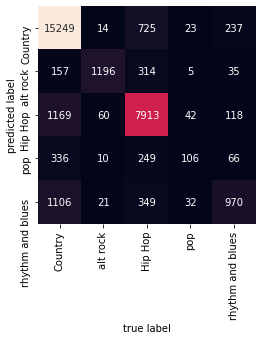

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test_df.ranker_genre, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,xticklabels=genres, yticklabels=genres)
plt.xlabel('true label')
plt.ylabel('predicted label');

EVALUATION OF CLASSIFIER

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(test_df.ranker_genre, predicted)
for n,genre in enumerate(genres):
    print(genre+'_precision: {}'.format(precision[n]))
    print(genre+'_recall: {}'.format(recall[n]))
    print(genre+'_fscore: {}'.format(fscore[n]))
    print(genre+'_support: {}'.format(support[n]))
    print()

Country_precision: 0.9385155096011817
Country_recall: 0.846367319753566
Country_fscore: 0.8900627462425216
Country_support: 18017

alt rock_precision: 0.7006444053895724
alt rock_recall: 0.9192928516525749
alt rock_fscore: 0.7952127659574468
alt rock_support: 1301

Hip Hop_precision: 0.8506772737045797
Hip Hop_recall: 0.8285863874345549
Hip Hop_fscore: 0.8394865266284743
Hip Hop_support: 9550

pop_precision: 0.13820078226857888
pop_recall: 0.5096153846153846
pop_fscore: 0.21743589743589742
pop_support: 208

rhythm and blues_precision: 0.39144471347861176
rhythm and blues_recall: 0.6802244039270687
rhythm and blues_fscore: 0.4969262295081967
rhythm and blues_support: 1426



TESTING UI

In [ ]:
text = input("Enter a lyric: ")
l = []
l.append(text)
print(text_clf.predict(l))

Enter a lyric: i stand for the red white and blue
['Country']


In [ ]:
data = train_df.append(test_df)
predicts = text_clf.predict_proba(data.lyric)
data['Country'], data['Hip_Hop'], data['Alt_Rock'], data['Pop'], data['RnB'] = ['','','','','']
for n,row in enumerate(data.itertuples()):
    data.loc[row.Index, 'Country'] = predicts[n][0]
    data.loc[row.Index, 'Hip_Hop'] = predicts[n][1]
    data.loc[row.Index, 'Alt_Rock'] = predicts[n][2]
    data.loc[row.Index, 'Pop'] = predicts[n][3]
    data.loc[row.Index, 'RnB'] = predicts[n][4]

TOP HIP-HOP SONGS

In [ ]:
columns_of_interest = ['artist', 'song', 'album', 'ranker_genre', 'Hip_Hop', 'Alt_Rock', 'Country','Pop','RnB']
data[columns_of_interest].sort_values(['Hip_Hop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
1401,Krayzie_Bone,A Thugga Level,Thug On Da Line (2001),Hip Hop,1,2.49137e-12,5.98811e-14,3.21222e-14,6.03973e-14
1401,Krayzie_Bone,A Thugga Level,Thug On Da Line (2001),Hip Hop,1,2.49137e-12,5.98811e-14,3.21222e-14,6.03973e-14
1401,Krayzie_Bone,A Thugga Level,Thug On Da Line (2001),Hip Hop,1,2.49137e-12,5.98811e-14,3.21222e-14,6.03973e-14
1401,Krayzie_Bone,A Thugga Level,Thug On Da Line (2001),Hip Hop,1,2.49137e-12,5.98811e-14,3.21222e-14,6.03973e-14
1401,Krayzie_Bone,A Thugga Level,Thug On Da Line (2001),Hip Hop,1,2.49137e-12,5.98811e-14,3.21222e-14,6.03973e-14
4111,Lil_Wayne,BM J.R.,Tha Carter (2004),Hip Hop,1,1.73796e-12,2.74943e-13,1.22271e-13,7.82516e-13
2074,Lil_Wayne,Ain't Worried Bout Shit,"Like Father, Like Son (2006)",Hip Hop,1,2.01365e-12,5.43874e-13,5.30444e-14,6.31525e-13
2074,Lil_Wayne,Ain't Worried Bout Shit,"Like Father, Like Son (2006)",Hip Hop,1,2.01365e-12,5.43874e-13,5.30444e-14,6.31525e-13
2074,Lil_Wayne,Ain't Worried Bout Shit,"Like Father, Like Son (2006)",Hip Hop,1,2.01365e-12,5.43874e-13,5.30444e-14,6.31525e-13
2074,Lil_Wayne,Ain't Worried Bout Shit,"Like Father, Like Son (2006)",Hip Hop,1,2.01365e-12,5.43874e-13,5.30444e-14,6.31525e-13


TOP ROCK SONGS

In [ ]:
columns_of_interest = ['artist', 'song', 'album', 'ranker_genre', 'Hip_Hop', 'Alt_Rock', 'Country','Pop','RnB']
data[columns_of_interest].sort_values(['Alt_Rock'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
40900,Blondie,Rapture,Greatest Hits: Deluxe Redux / Ghosts Of Downlo...,alt rock,7.72189e-10,1,3.31707e-09,1.86343e-09,7.0989e-10
40895,Blondie,Rapture,No Exit (1999),alt rock,7.72189e-10,1,3.31707e-09,1.86343e-09,7.0989e-10
40896,Blondie,Rapture,The Curse of Blondie (2003),alt rock,7.72189e-10,1,3.31707e-09,1.86343e-09,7.0989e-10
40893,Blondie,Rapture,Autoamerican (1980),alt rock,7.72189e-10,1,3.31707e-09,1.86343e-09,7.0989e-10
40892,Blondie,Rapture,Singles Collection: 1977-1982 (2009),alt rock,7.72189e-10,1,3.31707e-09,1.86343e-09,7.0989e-10
40900,Blondie,Rapture,Greatest Hits: Deluxe Redux / Ghosts Of Downlo...,alt rock,7.72189e-10,1,3.31707e-09,1.86343e-09,7.0989e-10
40894,Blondie,Rapture,The Platinum Collection (1994),alt rock,7.72189e-10,1,3.31707e-09,1.86343e-09,7.0989e-10
40897,Blondie,Rapture,Greatest Hits: Sight + Sound (2005),alt rock,7.72189e-10,1,3.31707e-09,1.86343e-09,7.0989e-10
29091,Uriah Heep,Lady In Black,Come Away Melinda - The Ballads (2001),alt rock,4.7894e-12,1,2.63838e-08,1.07863e-09,1.57433e-09
29088,Uriah Heep,Lady In Black,Salisbury (1971),alt rock,4.7894e-12,1,2.63838e-08,1.07863e-09,1.57433e-09


TOP COUNTRY SONGS

In [ ]:
columns_of_interest = ['artist', 'song', 'album', 'ranker_genre', 'Hip_Hop', 'Alt_Rock', 'Country','Pop','RnB']
data[columns_of_interest].sort_values(['Country'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
33354,Kris Kristofferson,Me and Bobby McGee,Kristofferson (1970),Country,6.56336e-11,7.79435e-10,1,2.5055e-10,5.06446e-10
33321,Kris Kristofferson,Me & Bobby McGee,The Austin Sessions (1999),Country,6.56336e-11,7.79435e-10,1,2.5055e-10,5.06446e-10
33362,Kris Kristofferson,Me and Bobby McGee,Live at the Philharmonic (1992),Country,6.56336e-11,7.79435e-10,1,2.5055e-10,5.06446e-10
33360,Johnny Cash,Me and Bobby McGee,På Österåker (1973),Country,6.56336e-11,7.79435e-10,1,2.5055e-10,5.06446e-10
33361,Willie Nelson,Me and Bobby McGee,Sings Kris Kristofferson (1979),Country,2.71509e-11,1.39266e-09,1,2.13178e-10,3.54495e-10
33355,Hank Snow,Me and Bobby McGee,Award Winners (1971),Country,1.71643e-11,1.31786e-09,1,3.20194e-10,3.95844e-10
50733,Hank Snow,The Golden Rocket,I'm Movin' On (2002),Country,2.83474e-11,1.27732e-09,1,5.72049e-11,1.08905e-09
50732,Hank Snow,The Golden Rocket,A Fool Such as I (2001),Country,2.83474e-11,1.27732e-09,1,5.72049e-11,1.08905e-09
17260,Hank Snow,Golden Rocket,Legendary (2003),Country,2.83474e-11,1.27732e-09,1,5.72049e-11,1.08905e-09
50725,Hank Snow,The Golden Rocket,Country Classics (1952),Country,2.83474e-11,1.27732e-09,1,5.72049e-11,1.08905e-09


TOP POP SONGS

In [ ]:
columns_of_interest = ['artist', 'song', 'album', 'ranker_genre', 'Hip_Hop', 'Alt_Rock', 'Country','Pop','RnB']
data[columns_of_interest].sort_values(['Pop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
46514,Modern Talking,Space Mix (The Ultimate Nonstop mix),Alone: The 8th Album (1999),pop,7.78392e-19,4.58861e-14,8.42738e-15,1,2.2623e-14
46514,Modern Talking,Space Mix (The Ultimate Nonstop mix),Alone: The 8th Album (1999),pop,7.78392e-19,4.58861e-14,8.42738e-15,1,2.2623e-14
36655,Modern Talking,No.1 Hit Medley,Back for Good: The 7th Album (1998),pop,9.0778e-15,2.89301e-10,8.15957e-11,1,5.06555e-10
36655,Modern Talking,No.1 Hit Medley,Back for Good: The 7th Album (1998),pop,9.0778e-15,2.89301e-10,8.15957e-11,1,5.06555e-10
52123,The Sweet,The Six Teens,Greatest Hits (2000),pop,9.63772e-12,3.02883e-09,3.6132e-09,1,9.77273e-10
52124,Sweet,The Sixteens,Strung Up (1975),pop,9.63772e-12,3.02883e-09,3.6132e-09,1,9.77273e-10
52121,The Sweet,The Six Teens,Best of Sweet (1993),pop,9.63772e-12,3.02883e-09,3.6132e-09,1,9.77273e-10
52119,The Sweet,The Six Teens,Desolation Boulevard (1974),pop,9.63772e-12,3.02883e-09,3.6132e-09,1,9.77273e-10
52119,The Sweet,The Six Teens,Desolation Boulevard (1974),pop,9.63772e-12,3.02883e-09,3.6132e-09,1,9.77273e-10
52124,Sweet,The Sixteens,Strung Up (1975),pop,9.63772e-12,3.02883e-09,3.6132e-09,1,9.77273e-10


TOP RnB SONGS

In [ ]:
columns_of_interest = ['artist', 'song', 'album', 'ranker_genre', 'Hip_Hop', 'Alt_Rock', 'Country','Pop','RnB']
data[columns_of_interest].sort_values(['RnB'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
53159,James Brown,Think,20 All-Time Greatest Hits! (1991),rhythm and blues,6.15116e-11,7.81032e-09,1.03595e-08,4.07417e-09,1
53160,James Brown,Think,Godfather of Soul (1993),rhythm and blues,6.15116e-11,7.81032e-09,1.03595e-08,4.07417e-09,1
53160,James Brown,Think,Godfather of Soul (1993),rhythm and blues,6.15116e-11,7.81032e-09,1.03595e-08,4.07417e-09,1
53153,James Brown,Think,Think! (1960),rhythm and blues,6.15116e-11,7.81032e-09,1.03595e-08,4.07417e-09,1
53160,James Brown,Think,Godfather of Soul (1993),rhythm and blues,6.15116e-11,7.81032e-09,1.03595e-08,4.07417e-09,1
53154,James Brown,Think,Live at the Apollo (1963),rhythm and blues,6.15116e-11,7.81032e-09,1.03595e-08,4.07417e-09,1
53164,James Brown,Think,50th Anniversary Collection (2003),rhythm and blues,6.15116e-11,7.81032e-09,1.03595e-08,4.07417e-09,1
53164,James Brown,Think,50th Anniversary Collection (2003),rhythm and blues,6.15116e-11,7.81032e-09,1.03595e-08,4.07417e-09,1
53164,James Brown,Think,50th Anniversary Collection (2003),rhythm and blues,6.15116e-11,7.81032e-09,1.03595e-08,4.07417e-09,1
53155,James Brown,Think,I Got You (I Feel Good) (1966),rhythm and blues,6.15116e-11,7.81032e-09,1.03595e-08,4.07417e-09,1


MOST ROCK LIKE HIP-HOP SONGS

In [ ]:
data[data.ranker_genre=='Hip Hop'][columns_of_interest].sort_values(['Alt_Rock'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
55514,Immortal_Technique,Ultimas Palabras,The Martyr (2011),Hip Hop,0.0068848,0.993111,4.17253e-06,7.74105e-08,3.98944e-07
62113,Childish_Gambino,Zombies,"""Awaken, My Love!"" (2016)",Hip Hop,0.00447648,0.986402,0.000664269,0.00716323,0.00129358
51452,Rakim,The Mystery (Who Is God?),18th Letter (1997),Hip Hop,0.0351814,0.964008,0.000715092,1.62958e-05,7.88283e-05
59691,Scarface,"Win, Lose Or Draw",My Homies (1998),Hip Hop,0.0718308,0.925009,0.00279234,0.000113043,0.000254684
56237,Scarface,Voices,Deeply Rooted (2015),Hip Hop,0.0446335,0.922402,0.0253748,0.00514364,0.0024463
56237,Scarface,Voices,Deeply Rooted (2015),Hip Hop,0.0446335,0.922402,0.0253748,0.00514364,0.0024463
30055,Lupe_Fiasco,Letting Go,Lasers (2011),Hip Hop,0.00350278,0.919379,0.0678519,0.00752345,0.00174299
4951,Lupe_Fiasco,Beautiful Lasers (2 Ways),Lasers (2011),Hip Hop,0.0460993,0.912935,0.0299055,0.00394856,0.00711216
33213,Raekwon,Masters Of Our Fate,Shaolin Vs. Wu-Tang (2011),Hip Hop,0.0715727,0.904345,0.0201261,0.000608894,0.00334718
18585,B.o.B,Have Nots,Psycadelik Thoughtz (2015),Hip Hop,0.0414671,0.89183,0.0439533,0.015987,0.00676227


MOST COUNTRY LIKE HIP-HOP SONGS

In [ ]:
data[data.ranker_genre=='Hip Hop'][columns_of_interest].sort_values(['Country'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
49158,Yelawolf,Tennessee Love,Trunk Muzik Returns (2013),Hip Hop,0.0220117,0.0384309,0.919946,0.00135883,0.0182529
49159,Yelawolf,Tennessee Love,Love Story (2015),Hip Hop,0.0220117,0.0384309,0.919946,0.00135883,0.0182529
28220,DMC,Just Like Me,"Checks, Thugs, and Rock n Roll (2006)",Hip Hop,0.11461,0.066685,0.756532,0.00480578,0.0573672
41538,De_La_Soul,Rev. Do Good 1,AOI:BIONIX (2001),Hip Hop,0.10435,0.0583567,0.71534,0.0109197,0.111033
11168,Yelawolf,Devil In My Veins,Love Story (2015),Hip Hop,0.0221509,0.18778,0.712348,0.0142661,0.0634544
9469,Scarface,Conspiracy Theory,The Last of a Dying Breed (2000),Hip Hop,0.248366,0.0546073,0.683981,0.00383706,0.00920852
9469,Scarface,Conspiracy Theory,The Last of a Dying Breed (2000),Hip Hop,0.248366,0.0546073,0.683981,0.00383706,0.00920852
56197,Yelawolf,Violin,Trial by Fire (2017),Hip Hop,0.0404018,0.285824,0.667572,0.00028734,0.00591501
25127,Childish_Gambino,I. Pink Toes,Because the Internet (2013),Hip Hop,0.125573,0.121256,0.637185,0.0678382,0.0481471
46978,Fabolous,Stay,Loso's Way (2009),Hip Hop,0.0625774,0.112939,0.61724,0.0819962,0.125247


MOST POP LIKE HIP-HOP SONGS

In [ ]:
data[data.ranker_genre=='Hip Hop'][columns_of_interest].sort_values(['Pop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
18586,Childish_Gambino,Have Some Love,"""Awaken, My Love!"" (2016)",Hip Hop,0.0243265,0.0394762,0.0584391,0.795699,0.0820596
36359,Mos_Def,No Hay Nada Mas,The Ecstatic (2009),Hip Hop,0.187123,0.032118,0.0134316,0.752444,0.0148833
756,Ludacris,9 Times Out Of 10,#IDGAF (2013),Hip Hop,0.265553,0.00402672,0.00369418,0.724391,0.0023352
33399,Childish_Gambino,Me and Your Mama,"""Awaken, My Love!"" (2016)",Hip Hop,0.099507,0.0211246,0.046866,0.689155,0.143348
46331,Drake,Sooner Than Later,So Far Gone (2009),Hip Hop,0.00246198,0.0621308,0.180123,0.636908,0.118376
33140,Scarface,Mary Jane,The Untouchable (1997),Hip Hop,0.226274,0.0244864,0.0762828,0.499855,0.173102
33140,Scarface,Mary Jane,The Untouchable (1997),Hip Hop,0.226274,0.0244864,0.0762828,0.499855,0.173102
12516,Lil_Wayne,Down,Tear Drop Tune 2 (2009),Hip Hop,0.0230512,0.352547,0.0296978,0.490159,0.104544
2073,Talib_Kweli,Ain't Waiting,Gutter Rainbows (2011),Hip Hop,0.00859633,0.321647,0.060691,0.488177,0.120889
41956,Lil_Wayne,Rock 'n' Roll,Tear Drop Tune 4 (2011),Hip Hop,0.395746,0.0493058,0.0163663,0.483362,0.0552204


MOST RnB LIKE HIP-HOP SONGS

In [ ]:
data[data.ranker_genre=='Hip Hop'][columns_of_interest].sort_values(['RnB'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
50639,Nelly,The Gank,Nellyville (2002),Hip Hop,0.00291139,0.0224831,0.0248497,0.103246,0.846509
49823,Mos_Def,The Beggar,The New Danger (2004),Hip Hop,0.000290083,0.00514461,0.165576,0.0190343,0.809955
21904,Drake,I Get Lonley Too,Young Sweet Jones (2010),Hip Hop,0.0674909,0.00618386,0.0155552,0.140872,0.769898
39889,Childish_Gambino,Pop Thieves (Make It Feel Good),STN MTN / Kauai (2014),Hip Hop,0.0441824,0.0277831,0.0247409,0.136066,0.767228
39889,Childish_Gambino,Pop Thieves (Make It Feel Good),STN MTN / Kauai (2014),Hip Hop,0.0441824,0.0277831,0.0247409,0.136066,0.767228
39889,Childish_Gambino,Pop Thieves (Make It Feel Good),STN MTN / Kauai (2014),Hip Hop,0.0441824,0.0277831,0.0247409,0.136066,0.767228
46389,Talib_Kweli,Soul Music,Liberation (2007),Hip Hop,0.0452979,0.0633351,0.0450702,0.102102,0.744195
47982,Guru,Supa Love,"Jazzmatazz, Vol. 3: Streetsoul (2000)",Hip Hop,0.192441,0.00676562,0.030014,0.0371012,0.733678
61738,LL_Cool_J,You're in My Heart,Walking With A Panther (1989),Hip Hop,0.00338194,0.0260856,0.245399,0.00480365,0.72033
55471,Nelly,U Know U Want To,M.O. (2013),Hip Hop,0.0721801,0.0519252,0.019921,0.186421,0.669552


MOST HIP-HOP LIKE ROCK SONGS

In [ ]:
data[data.ranker_genre=='alt rock'][columns_of_interest].sort_values(['Hip_Hop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
16140,Hollywood Undead,Gangsta Sexy,American Tragedy (2011),alt rock,0.999877,7.43381e-05,4.40916e-06,1.02567e-05,3.35924e-05
49324,Sublime,Thanx Dub,40oz. to Freedom (1992),alt rock,0.999555,0.000433258,1.14086e-05,8.19683e-08,3.8444e-07
43810,System of a Down,Shame,Lonely Day (2006),alt rock,0.998825,0.00117185,7.97301e-07,2.01622e-06,4.6112e-07
28657,Blood on the Dance Floor,Keys To The Bakery,It's Hard To Be A Diamond In A Rhinestone Worl...,alt rock,0.998643,0.000806098,0.000249681,0.000204765,9.66285e-05
49306,Sublime,Thanks Dub,Second Hand Smoke (1997),alt rock,0.998484,0.00142303,9.03643e-05,5.34988e-07,2.15852e-06
34237,Blood on the Dance Floor,Money And Hoes,Let's Start A Riot (2007),alt rock,0.997846,0.00207987,2.54959e-05,1.64405e-05,3.23812e-05
55444,Fear Before the March of Flames,Tycho,Fear Before (2008),alt rock,0.992161,0.00111623,0.0031117,0.00195766,0.001653
9794,I Set My Friends on Fire,Crank That,You Can't Spell Slaughter Without Laughter (2008),alt rock,0.986047,0.00353494,0.00424455,0.00298531,0.00318786
8071,Hollywood Undead,Cashed Out,V (2017),alt rock,0.985128,0.0143884,0.000243651,0.00011886,0.000120611
44331,Emmure,Shinjuku Masterlord,Look at Yourself (2017),alt rock,0.984488,0.0152964,3.93324e-05,8.11806e-05,9.55004e-05


MOST COUNTRY LIKE ROCK SONGS

In [ ]:
data[data.ranker_genre=='alt rock'][columns_of_interest].sort_values(['Country'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
60766,Misfits,You Belong To Me,Project 1950 (2003),alt rock,1.13588e-07,1.73605e-05,0.999957,9.84196e-06,1.5277e-05
38266,Misfits,Only Make Believe,Project 1950 (2003),alt rock,1.88475e-08,2.36601e-05,0.999938,1.48665e-06,3.68634e-05
37155,Bad Religion,O Come All Ye Faithful,Christmas Songs (2013),alt rock,9.73438e-06,0.000223664,0.998988,0.000576288,0.000202694
7779,Twenty One Pilots,Can't Help Falling in Love,Holding On to You (2013),alt rock,3.78152e-06,0.000538702,0.998434,0.000244848,0.000778994
58968,Bad Religion,White Christmas,Christmas Songs (2013),alt rock,3.83011e-08,1.0403e-06,0.996188,4.48263e-06,0.00380672
54699,The Pogues,Train of Love,Peace and Love (1989),alt rock,7.51114e-06,0.00413915,0.993178,0.00192768,0.000748007
56526,Frank Iero,Walk the Line,For Jamia... (2013),alt rock,3.27773e-06,0.00686015,0.990815,0.000566966,0.00175477
27856,NOFX,Johnny B. Goode,The Longest EP (2010),alt rock,8.74352e-05,0.00747481,0.990185,0.00029858,0.00195426
61521,Dropkick Murphys,You'll Never Walk Alone,11 Short Stories of Pain & Glory (2017),alt rock,1.66214e-06,0.0117752,0.988031,9.75256e-05,9.50439e-05
32774,Social Distortion,Making Believe,Somewhere Between Heaven and Hell (1992),alt rock,4.43697e-06,0.00117522,0.984971,0.000570128,0.0132796


MOST POP LIKE ROCK SONGS

In [ ]:
data[data.ranker_genre=='alt rock'][columns_of_interest].sort_values(['Pop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
4658,The Damned,Ballroom Blitz,Machine Gun Etiquette (1979),alt rock,4.42627e-09,4.47084e-08,8.15935e-09,1,9.79262e-09
54648,A Static Lullaby,Toxic,Rattlesnake! (2008),alt rock,1.2224e-06,0.00105536,6.59203e-07,0.998942,7.22893e-07
54648,A Static Lullaby,Toxic,Rattlesnake! (2008),alt rock,1.2224e-06,0.00105536,6.59203e-07,0.998942,7.22893e-07
48862,Heart,Te Quedaras En La Mañana,Desire Walks On (1993),alt rock,0.000217495,0.00012347,0.000592608,0.997074,0.00199268
18298,Joan Jett and the Blackhearts,Hanky Panky,Fetish (1999),alt rock,0.000127941,0.000349098,0.000895295,0.996851,0.00177659
7867,The Bouncing Souls,Candy,The Good The Bad And The Argyle (1994),alt rock,0.000249278,0.000448541,0.0011082,0.995796,0.00239805
29029,Blind Guardian,La Cosecha Del Dolor,A Night At The Opera (2002),alt rock,0.00139307,0.000858428,0.00168803,0.994188,0.00187247
33792,Blind Guardian,Mies Del Dolor,A Night At The Opera (2002),alt rock,0.00391278,0.00203675,0.00288088,0.989833,0.00133697
7592,Blondie,Call Me,Blonde and Beyond (1993),alt rock,0.00242834,0.00433504,0.00362021,0.984005,0.0056112
3201,Bad Religion,Angels We Have Heard on High,Christmas Songs (2013),alt rock,0.000135084,0.00730813,0.00257719,0.951743,0.0382363


MOST RnB LIKE ROCK SONGS

In [ ]:
data[data.ranker_genre=='alt rock'][columns_of_interest].sort_values(['RnB'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
53415,Misfits,This Magic Moment,Project 1950 (2003),alt rock,9.36256e-07,1.78051e-05,0.000182406,6.43439e-05,0.999735
1738,Sonic Youth,Addicted to Love,The Whitey Album (1989),alt rock,1.19147e-05,0.000229302,5.93278e-05,5.76971e-05,0.999642
38334,Iggy Pop,Only the Lonely,Après (2012),alt rock,1.17562e-07,3.03346e-05,0.000928209,1.40429e-05,0.999027
14687,The Cramps,Fever,Songs The Lord Taught Us (1980),alt rock,3.79915e-06,0.00149194,0.000363804,0.000431531,0.997709
28048,Motörhead,Jumpin' Jack Flash,Under Cöver (2017),alt rock,0.000439851,0.00171858,0.000624721,0.000312663,0.996904
29874,Joan Jett and the Blackhearts,Let's Do It,Jett Rock (2003),alt rock,0.000248119,0.00190427,0.0042407,0.00038286,0.993224
22132,The Slits,I Heard It Through the Grapevine,Cut (1979),alt rock,6.73683e-06,0.0133021,0.00027891,6.28458e-05,0.986349
22132,The Slits,I Heard It Through the Grapevine,Cut (1979),alt rock,6.73683e-06,0.0133021,0.00027891,6.28458e-05,0.986349
4905,Fall Out Boy,Beat It,Folie à Deux (2008),alt rock,0.000742446,0.0112404,0.000132506,0.0018253,0.986059
4904,Pierce the Veil,Beat It,A Flair for the Dramatic (2007),alt rock,0.000692159,0.0123801,0.000135715,0.00106833,0.985724


MOST HIP-HOP LIKE COUNTRY SONGS

In [ ]:
data[data.ranker_genre=='Country'][columns_of_interest].sort_values(['Hip_Hop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
53731,Taylor Swift,Thug Story,Fearless (2008),Country,0.998355,0.000808789,0.000358226,0.000265008,0.000212714
49692,"Hank Williams, Jr.",The American Dream,The Complete Hank Williams Jr. (1999),Country,0.967803,0.0155723,0.0117263,0.00272434,0.00217393
19780,George Jones,High-Tech Redneck,The George Jones Collection (1999),Country,0.964748,0.0135057,0.0193811,0.00133275,0.00103231
19779,George Jones,High-Tech Redneck,High-Tech Redneck (1993),Country,0.964748,0.0135057,0.0193811,0.00133275,0.00103231
8495,Johnny Cash,Chicken in Black,Original Hits (2004),Country,0.947148,0.00837099,0.0398406,0.000369369,0.00427101
1924,Willie Nelson,Ain't Goin' Down on Brokeback Mountain,Lost Highway (2009),Country,0.929034,0.0303926,0.0238545,0.00890373,0.0078147
38230,Brad Paisley,Online,5th Gear (2007),Country,0.91077,0.0575191,0.0198048,0.00989483,0.00201119
27417,Buck Owens,It's a Monster's Holiday,It's a Monster's Holiday (1974),Country,0.882349,0.0714848,0.0190318,0.00113033,0.0260038
15502,Elvis Presley,Fort Lauderdale Chamber Of Commerce,Girl Happy (1965),Country,0.860668,0.0889518,0.0172097,0.0070953,0.0260752
1983,Charlie Daniels,Ain't No Law in California,Road Dogs (2000),Country,0.857206,0.0411128,0.0988106,0.0018599,0.00101097


MOST ROCK LIKE COUNTRY SONGS

In [ ]:
data[data.ranker_genre=='Country'][columns_of_interest].sort_values(['Alt_Rock'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
31170,Olivia Newton-John,Long Live Love (German Version),"If You Love Me, Let Me Know (1974)",Country,1.99454e-05,0.998824,0.000535563,3.63109e-05,0.000584441
18614,Willie Nelson,Have You Ever Seen the Rain?,To All the Girls.. (2013),Country,0.000178412,0.984546,0.00587473,0.00376894,0.00563176
18612,Johnny Cash,Have You Ever Seen the Rain?,Rainbow (1985),Country,0.000138598,0.983815,0.00466118,0.004252,0.00713294
30110,Elvis Presley,Life,Love Letters From Elvis (1971),Country,0.000113893,0.970247,0.0262185,0.00046736,0.00295297
13276,Elvis Presley,Edge Of Reality,Almost In Love (1970),Country,0.00230164,0.969122,0.00405156,0.019568,0.00495669
34058,Eric Church,Mixed Drinks about Feelings,Mr. Misunderstood (2015),Country,0.00132471,0.959059,0.0210822,0.0154769,0.00305675
8640,Hank Snow,Christmas Wants,Christmas With Hank Snow (1967),Country,0.000622002,0.957782,0.0379009,0.00027863,0.00341678
8641,Hank Snow,Christmas Wants,The Singing Ranger Vol. 3 (1992),Country,0.000622002,0.957782,0.0379009,0.00027863,0.00341678
53764,Tim McGraw,Tickin' Away,Tim McGraw And The Dancehall Doctors (2002),Country,0.00444449,0.953707,0.0261166,0.00821584,0.00751579
15840,Martina McBride,From the Ashes,Emotion (1999),Country,0.00438875,0.951852,0.0380031,0.00244495,0.00331131


MOST POP LIKE COUNTRY SONGS

In [ ]:
data[data.ranker_genre=='Country'][columns_of_interest].sort_values(['Pop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
30247,Olivia Newton-John,Lift Me Up,(2) (2002),Country,4.67445e-07,9.4862e-05,6.81293e-05,0.999803,3.3762e-05
24786,Barbara Mandrell,I'm a Believer,Get to the Heart (1985),Country,6.50168e-08,2.76775e-06,0.00023526,0.999746,1.63866e-05
13895,Olivia Newton-John,Everything I Own,Olivia (1972),Country,2.20879e-07,0.000107969,0.00187973,0.997929,8.3274e-05
13896,Olivia Newton-John,Everything I Own,48 Original Tracks (1994),Country,2.20879e-07,0.000107969,0.00187973,0.997929,8.3274e-05
42101,Toby Keith,Rockin' Around the Christmas Tree,A Classic Christmas (2007),Country,4.84771e-08,2.52949e-06,0.00325007,0.996731,1.67697e-05
42480,Sara Evans,Run Rudolph Run,At Christmas (2014),Country,3.20513e-05,0.000490569,0.00168806,0.996689,0.00110023
42481,Dwight Yoakam,Run Run Rudolph,Come On Christmas (1997),Country,0.000502396,0.00311854,0.0135754,0.976979,0.00582449
33640,Elvis Presley,Merry Christmas Baby,Elvis Sings The Wonderful World Of Christmas (...,Country,3.99384e-06,3.08344e-05,0.00927742,0.975128,0.0155601
19410,Willie Nelson,Here Comes Santa Claus,Pretty Paper (1979),Country,3.01186e-06,3.49768e-06,0.0313405,0.96835,0.000303285
19409,Kitty Wells,Here Comes Santa Claus,Christmas Day with Kitty Wells (1962),Country,3.20916e-06,4.00101e-06,0.0378337,0.961843,0.00031632


MOST RnB LIKE COUNTRY SONGS

In [ ]:
data[data.ranker_genre=='Country'][columns_of_interest].sort_values(['RnB'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
35039,Glen Campbell,My Girl,Rhinestone Cowboy (1975),Country,8.91425e-08,1.28833e-07,5.01408e-07,9.89224e-07,0.999998
45390,Anne Murray,Smile,I'll Be Seeing You (2004),Country,9.87199e-09,6.28388e-06,2.97038e-05,1.43287e-05,0.99995
42384,Lee Greenwood,Ruby,This Is My Country (1988),Country,2.18319e-07,1.21599e-05,3.66188e-05,3.69295e-06,0.999947
1606,Willie Nelson,Ac-Cent-Tchu-Ate the Positive,What a Wonderful World (1988),Country,4.48508e-06,3.85563e-05,1.03542e-05,6.41622e-06,0.99994
52985,Ronnie Milsap,These Foolish Things (Remind Me of You),True Believer (1993),Country,1.01531e-07,2.5028e-05,4.87304e-05,3.6202e-06,0.999923
45383,Eddy Arnold,Smile,Sometimes I'm Happy (RCA Victor) (1964),Country,1.42648e-08,6.71451e-06,6.6335e-05,1.93079e-05,0.999908
61541,Barbara Mandrell,You're All I Need to Get By,This Time I Almost Made It (1974),Country,1.63257e-07,5.67222e-05,9.36692e-05,4.89674e-06,0.999845
61805,Anne Murray,You've Got a Friend,Talk It Over in the Morning (1971),Country,1.08156e-07,3.05477e-05,0.0001128,1.61846e-05,0.99984
38523,Ferlin Husky,Out in the Cold Again,Boulevard of Broken Dreams (1957),Country,1.55742e-07,2.20797e-05,0.000173913,4.63064e-06,0.999799
43634,Willie Nelson,Seven Spanish Angels,Revolutions of Time...The Journey 1975/1993 (1...,Country,1.422e-06,6.66594e-05,0.000140609,1.23658e-05,0.999779


MOST HIP-HOP LIKE POP SONGS

In [ ]:
data[data.ranker_genre=='pop'][columns_of_interest].sort_values(['Hip_Hop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
21860,Hannah Montana,I Forgive Yiew,Miley Cyrus & Her Dead Petz (2015),pop,0.812042,0.0915462,0.0428523,0.0364154,0.0171445
29453,Aaron Carter,Leave It Up To Me,Most Requested Hits (2003),pop,0.802558,0.0246454,0.00854229,0.00856431,0.15569
48400,Katy Perry,Swish Swish,Witness (2017),pop,0.699161,0.00313322,0.000305233,0.296394,0.00100598
48400,Katy Perry,Swish Swish,Witness (2017),pop,0.699161,0.00313322,0.000305233,0.296394,0.00100598
53561,Katy Perry,This is How We Do,Prism (2013),pop,0.678267,0.00327337,0.000930779,0.316368,0.00116075
53561,Katy Perry,This is How We Do,Prism (2013),pop,0.678267,0.00327337,0.000930779,0.316368,0.00116075
42580,Giorgio,Rush Rush,Scarface (1983),pop,0.672674,0.153359,0.0936312,0.0574414,0.0228945
9184,Aaron Carter,Come Follow Me,Oh Aaron (2001),pop,0.614346,0.0170075,0.00200948,0.331551,0.0350854
33820,Hannah Montana,Milky Milky Milk,Miley Cyrus & Her Dead Petz (2015),pop,0.541062,0.257441,0.119714,0.0237215,0.0580617
5675,Christina Aguilera,Bionic,Bionic (2010),pop,0.510905,0.0959598,0.00428322,0.378621,0.0102316


MOST ROCK LIKE POP SONGS

In [ ]:
data[data.ranker_genre=='pop'][columns_of_interest].sort_values(['Alt_Rock'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
2722,Hanson,Already Home,Anthem (2013),pop,0.00136448,0.94258,0.0425457,0.0115264,0.001983
26312,Hannah Montana,Inspired,Younger Now (2017),pop,0.0012353,0.914746,0.0256108,0.039462,0.0189454
7742,Debbie Gibson,Can't Do It Alone,Think With Your Heart (1995),pop,0.000586505,0.881033,0.0328146,0.030831,0.054735
24675,Katy Perry,I'm Still Breathing,One of the Boys (2008),pop,0.00829337,0.852185,0.00945359,0.127009,0.00305914
5611,Katy Perry,Bigger Than Me,Witness (2017),pop,0.00642366,0.85102,0.00675494,0.127206,0.00859582
31570,Christina Aguilera,Lotus Intro,Lotus (2012),pop,0.0208148,0.847312,0.0602749,0.0477159,0.0238821
35604,Spice Girls,Naked,Spice (1996),pop,0.00446441,0.793433,0.0793787,0.0432071,0.0795172
42579,Backstreet Boys,Rush Over Me,Never Gone (2005),pop,0.0298145,0.792825,0.059219,0.0471555,0.0709857
46660,Katy Perry,Spit,Katy Hudson (2001),pop,0.000495946,0.777701,0.201551,0.000357494,0.0198943
15664,Debbie Gibson,Free Me,"Body, Mind, Soul (1992)",pop,0.000395661,0.763396,0.13749,0.0263891,0.072329


MOST COUNTRY LIKE POP SONGS

In [ ]:
data[data.ranker_genre=='pop'][columns_of_interest].sort_values(['Country'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
60858,The Monkees,You Can't Judge A Book By Looking At The Cover,Live 1967 (1987),pop,0.000418398,0.000923416,0.993836,0.000382834,0.00443921
23749,Jessica Simpson,I'll Be Home for Christmas,Happy Christmas (2010),pop,8.58378e-07,0.000116479,0.974324,0.0241806,0.00137834
4385,Hannah Montana,Back To Tennessee,Hannah Montana: The Movie (2009),pop,0.000386186,0.0322769,0.959172,0.000982443,0.00718264
29682,Jessica Simpson,"Let It Snow, Let It Snow, Let It Snow",Rejoyce: The Christmas Album (2004),pop,0.000123162,0.00457683,0.902807,0.0890014,0.00349132
44457,Jonas Brothers,Should've Said No,Music from the 3D Concert Experience (2009),pop,8.97495e-06,0.00037746,0.881189,0.117818,0.000606414
44457,Jonas Brothers,Should've Said No,Music from the 3D Concert Experience (2009),pop,8.97495e-06,0.00037746,0.881189,0.117818,0.000606414
25335,The Monkees,If I Learned to Play the Violin,Headquarters (1967),pop,0.0197279,0.0433969,0.876631,0.0126907,0.0475536
20101,The Monkees,Hollywood,Missing Links Volume 3 (1996),pop,0.000352991,0.0418318,0.871638,0.0664983,0.0196793
6181,Bad Boys Blue,Blue Moon,Heart Beat (1986),pop,8.56296e-05,0.000712959,0.842009,0.156363,0.0008291
6181,Bad Boys Blue,Blue Moon,Heart Beat (1986),pop,8.56296e-05,0.000712959,0.842009,0.156363,0.0008291


MOST RnB LIKE POP SONGS

In [ ]:
data[data.ranker_genre=='pop'][columns_of_interest].sort_values(['Country'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
60858,The Monkees,You Can't Judge A Book By Looking At The Cover,Live 1967 (1987),pop,0.000418398,0.000923416,0.993836,0.000382834,0.00443921
23749,Jessica Simpson,I'll Be Home for Christmas,Happy Christmas (2010),pop,8.58378e-07,0.000116479,0.974324,0.0241806,0.00137834
4385,Hannah Montana,Back To Tennessee,Hannah Montana: The Movie (2009),pop,0.000386186,0.0322769,0.959172,0.000982443,0.00718264
29682,Jessica Simpson,"Let It Snow, Let It Snow, Let It Snow",Rejoyce: The Christmas Album (2004),pop,0.000123162,0.00457683,0.902807,0.0890014,0.00349132
44457,Jonas Brothers,Should've Said No,Music from the 3D Concert Experience (2009),pop,8.97495e-06,0.00037746,0.881189,0.117818,0.000606414
44457,Jonas Brothers,Should've Said No,Music from the 3D Concert Experience (2009),pop,8.97495e-06,0.00037746,0.881189,0.117818,0.000606414
25335,The Monkees,If I Learned to Play the Violin,Headquarters (1967),pop,0.0197279,0.0433969,0.876631,0.0126907,0.0475536
20101,The Monkees,Hollywood,Missing Links Volume 3 (1996),pop,0.000352991,0.0418318,0.871638,0.0664983,0.0196793
6181,Bad Boys Blue,Blue Moon,Heart Beat (1986),pop,8.56296e-05,0.000712959,0.842009,0.156363,0.0008291
6181,Bad Boys Blue,Blue Moon,Heart Beat (1986),pop,8.56296e-05,0.000712959,0.842009,0.156363,0.0008291


MOST HIP-HOP LIKE RnB SONGS

In [ ]:
data[data.ranker_genre=='rhythm and blues'][columns_of_interest].sort_values(['Hip_Hop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
9428,Usher,Confessions (Interlude),Confessions (2004),rhythm and blues,0.964402,0.00334472,0.00773128,0.0071539,0.0173678
47664,Prince,Style,Emancipation (1996),rhythm and blues,0.91841,0.0117807,0.00535832,0.00238831,0.0620629
4389,Beyoncé Knowles,Back Up,B'Day (2006),rhythm and blues,0.901717,0.00203184,0.0010855,0.00294022,0.0922259
43688,Beyoncé Knowles,Sexy Lil' Thug,Speak My Mind (2005),rhythm and blues,0.900474,4.34896e-05,3.19892e-05,0.000299385,0.0991512
43688,Beyoncé Knowles,Sexy Lil' Thug,Speak My Mind (2005),rhythm and blues,0.900474,4.34896e-05,3.19892e-05,0.000299385,0.0991512
41285,Prince,Release It,Graffiti Bridge (1990),rhythm and blues,0.896935,0.0403719,0.0185788,0.00950548,0.0346091
62097,Prince,Zannalee,Chaos and Disorder (1996),rhythm and blues,0.891595,0.0162722,0.024637,0.0195516,0.0479439
41814,Prince,Ripopgodazippa,Crystal Ball (1998),rhythm and blues,0.880114,0.0601015,0.00253983,0.00091503,0.0563298
12190,Prince,Don't Play Me,The Truth (1998),rhythm and blues,0.856828,0.0500326,0.0431593,0.00971199,0.0402679
6348,Prince,Bob George,Black Album (1994),rhythm and blues,0.840353,0.00793941,0.000356027,0.000320543,0.151031


MOST ROCK LIKE RnB SONGS

In [ ]:
data[data.ranker_genre=='rhythm and blues'][columns_of_interest].sort_values(['Alt_Rock'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
13854,The Supremes,Everyday People,Let The Sunshine In (1969),rhythm and blues,8.11679e-05,0.991741,0.000225954,7.87034e-05,0.00787299
9395,Tina Turner,Complicated Disaster,All the Best (2004),rhythm and blues,0.000353517,0.957073,0.0298683,0.00885123,0.00385407
13398,Prince,Emale,Emancipation (1996),rhythm and blues,0.0150371,0.936664,0.0245963,0.00496008,0.0187425
45585,Ray Charles,So Help Me God,My World (1993),rhythm and blues,0.000954459,0.923255,0.0436194,0.00701644,0.0251545
14366,Prince,Family Name,The Rainbow Children (2001),rhythm and blues,0.0722641,0.917826,0.00571154,0.000119268,0.00407865
19395,Prince,Here,MPLSoUND (2009),rhythm and blues,0.0142877,0.914977,0.00969209,0.00177,0.0592729
35949,Janet Jackson,New Agenda,janet. (1993),rhythm and blues,0.0429166,0.905879,0.0250046,0.00201903,0.0241806
12777,Prince,Dreamer,LotusFlow3r (2009),rhythm and blues,0.00709151,0.900056,0.0163258,0.00103165,0.0754947
56593,Prince,Wall Of Berlin,LotusFlow3r (2009),rhythm and blues,0.0196625,0.883224,0.0697599,0.00667192,0.0206817
57408,Prince,Welcome 2 The Dawn,The Truth (1998),rhythm and blues,0.00879163,0.871435,0.0757278,0.0155649,0.0284808


MOST COUNTRY LIKE RnB SONGS

In [ ]:
data[data.ranker_genre=='rhythm and blues'][columns_of_interest].sort_values(['Country'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
24463,Tina Turner,I'm Moving On,Tina Turns the Country On! (1974),rhythm and blues,2.50196e-08,9.31738e-08,0.999992,6.01103e-08,7.80012e-06
25976,Al Green,In The Garden,Precious Lord (1982),rhythm and blues,4.32946e-08,5.55042e-06,0.999989,9.71947e-07,4.46037e-06
40066,Al Green,Precious Lord,Precious Lord (1982),rhythm and blues,5.44438e-07,6.16574e-05,0.999768,1.40205e-05,0.00015531
10521,Sam Cooke,Danny Boy,Sam Cooke (1957),rhythm and blues,9.24983e-07,3.33306e-05,0.999448,9.60419e-06,0.000508508
19684,Ray Charles,"Hey, Good Lookin'",Modern Sounds in Country and Western Music (1962),rhythm and blues,0.000198132,6.7163e-05,0.999298,0.000203651,0.000233316
19349,Tina Turner,Help Me Make It Through the Night,Tina Turns the Country On! (1974),rhythm and blues,7.16595e-08,1.14428e-05,0.999281,2.80265e-06,0.000705032
19349,Tina Turner,Help Me Make It Through the Night,Tina Turns the Country On! (1974),rhythm and blues,7.16595e-08,1.14428e-05,0.999281,2.80265e-06,0.000705032
13390,Aretha Franklin,Elusive Butterfly,Soul '69 (1969),rhythm and blues,3.21074e-07,9.72734e-05,0.999194,1.95446e-06,0.000705957
37199,Diana Ross,O Little Town of Bethlehem,Christmas In Vienna (1993),rhythm and blues,7.88029e-10,6.47529e-07,0.998835,3.98979e-08,0.00116471
37200,Diana Ross,O Little Town of Bethlehem,Making Spirits Bright (1994),rhythm and blues,7.88029e-10,6.47529e-07,0.998835,3.98979e-08,0.00116471


MOST POP LIKE RnB SONGS

In [ ]:
data[data.ranker_genre=='rhythm and blues'][columns_of_interest].sort_values(['Pop'], ascending=False).head(10)

,artist,song,album,ranker_genre,Hip_Hop,Alt_Rock,Country,Pop,RnB
57599,Al Green,What Christmas Means to Me,The Christmas Album (1983),rhythm and blues,6.55243e-08,2.59155e-06,0.000936578,0.997967,0.00109337
35643,The Supremes,Nathan Jones,Touch (1971),rhythm and blues,1.0316e-05,0.000172251,0.000550999,0.995224,0.00404273
18340,Diana Ross,Happy Christmas (War is Over),A Very Special Season (1994),rhythm and blues,1.47781e-06,3.53023e-05,0.00184134,0.995007,0.00311477
54220,Michael Jackson,Todo Mi Amor Eres Tu,Bad (1987),rhythm and blues,4.26958e-05,2.74249e-05,5.83095e-05,0.994739,0.00513282
24705,The Supremes,I'm The Greatest Star,"Diana Ross & The Supremes Sing And Perform ""Fu...",rhythm and blues,1.23881e-06,6.0268e-05,1.27818e-05,0.994426,0.00550014
22793,The Jackson 5,I Saw Mommy Kissing Santa Claus,Jackson 5 Christmas Album (1970),rhythm and blues,2.18583e-05,6.20505e-05,0.00107462,0.992007,0.0068349
57598,Stevie Wonder,What Christmas Means to Me,Someday at Christmas (1967),rhythm and blues,9.10379e-07,1.22995e-05,0.00852164,0.990115,0.00135041
23091,The Isley Brothers,I Wanna Be With You (Parts 1 & 2),Winner Takes All (1979),rhythm and blues,5.72183e-06,0.000230394,0.000135756,0.988946,0.0106825
23091,The Isley Brothers,I Wanna Be With You (Parts 1 & 2),Winner Takes All (1979),rhythm and blues,5.72183e-06,0.000230394,0.000135756,0.988946,0.0106825
14023,Whitney Houston,"Exhale (Shoop, Shoop)",The Greatest Hits (2000),rhythm and blues,0.00402171,0.00755783,0.00461905,0.980274,0.00352766


WORD CLOUD

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
comment_words = '' 
stopwords = set(STOPWORDS)

GENERAL WORD CLOUD

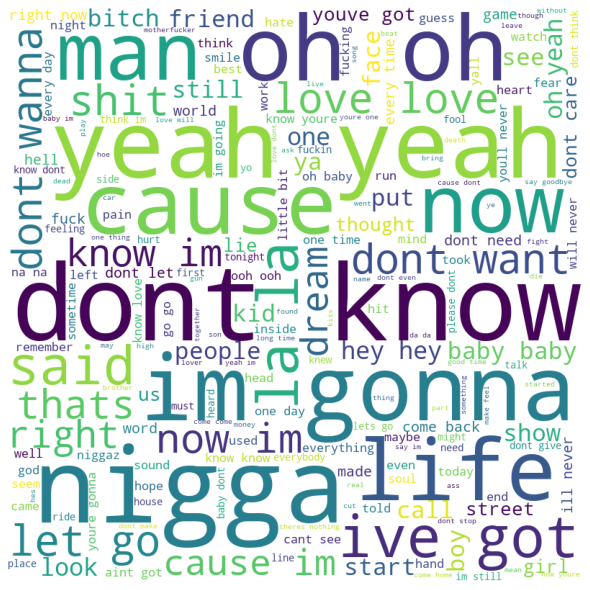

In [ ]:
for val in lyrics_by_song.lyric:
  val = str(val) 
  tokens = val.split() 
  for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower() 
  comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)   
plt.show()

COUNTRY WORD CLOUD

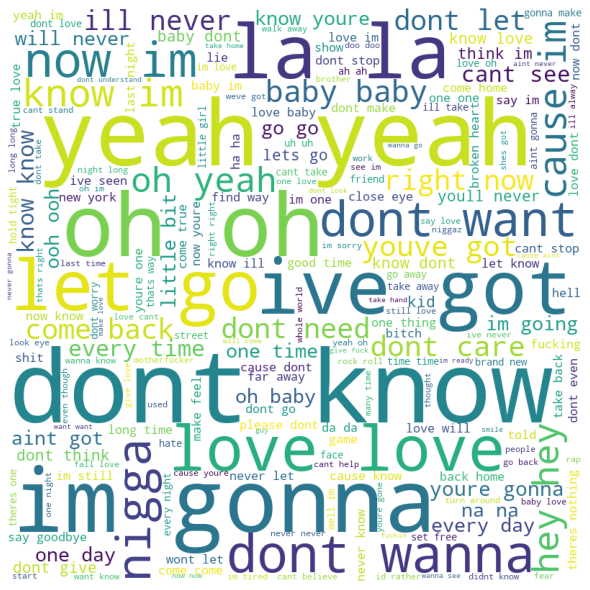

In [ ]:
if([lyrics_by_song.ranker_genre=='Country']):
  for val in lyrics_by_song.lyric: 
      val = str(val)  
      tokens = val.split() 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
      comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

ROCK WORD CLOUD

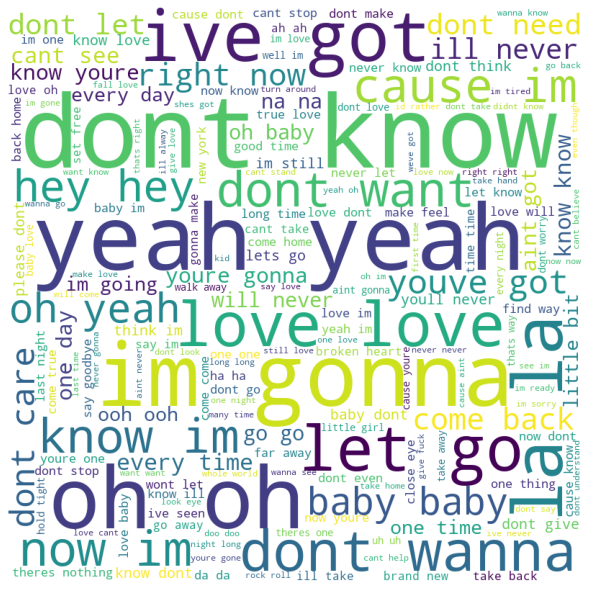

In [ ]:
if([lyrics_by_song.ranker_genre=='alt rock']):
  for val in lyrics_by_song.lyric: 
      val = str(val)  
      tokens = val.split() 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
      comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

HIP HOP WORD CLOUD

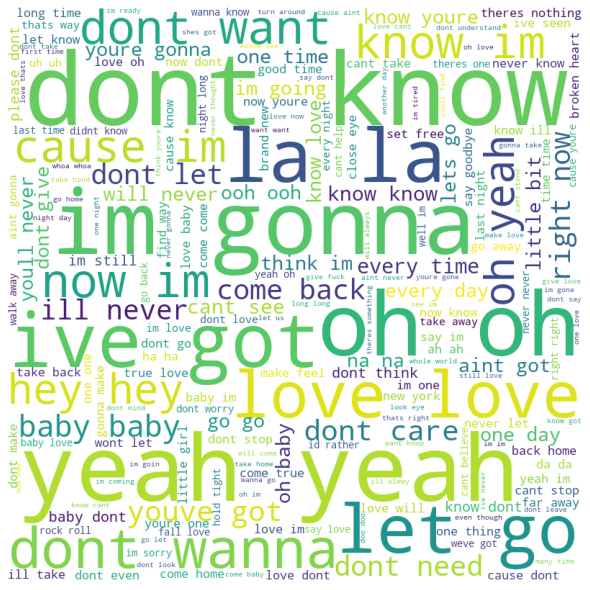

In [ ]:
if([lyrics_by_song.ranker_genre=='Hip Hop']):
  for val in lyrics_by_song.lyric: 
      val = str(val)  
      tokens = val.split() 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
      comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

POP WORD CLOUD

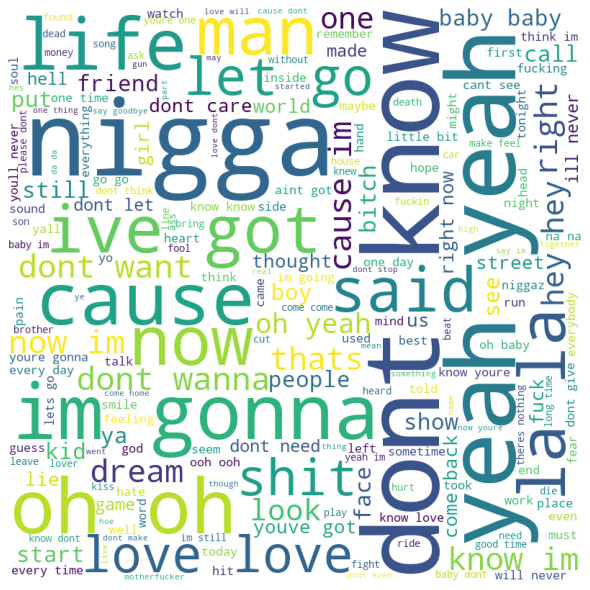

In [ ]:
if([lyrics_by_song.ranker_genre=='pop']):
  for val in lyrics_by_song.lyric: 
      val = str(val)  
      tokens = val.split() 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
      comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

RnB WORD CLOUD

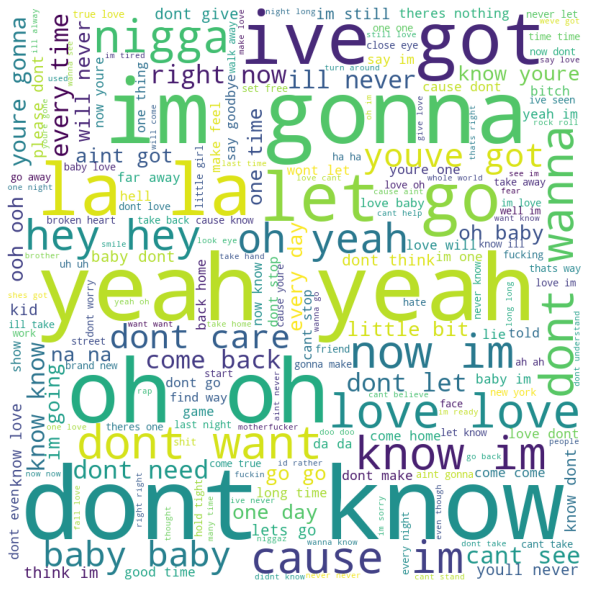

In [ ]:
if([lyrics_by_song.ranker_genre=='rhythm and blues']):
  for val in lyrics_by_song.lyric: 
      val = str(val)  
      tokens = val.split() 
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
      comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()